In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import sys
import torch
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
# sys.path.append('..')

In [2]:
class LinearNDInterpolatorExt(object):
    def __init__(self, points,values):
        self.funcinterp = LinearNDInterpolator(points,values)
        self.funcnearest = NearestNDInterpolator(points,values)
    def __call__(self,*args):
        t = self.funcinterp(*args)
        if not np.isnan(t):
            return t.item(0)
        else:
            return self.funcnearest(*args)

In [3]:
df = pd.read_csv('csv/acc-s38.348.csv')
df

,Pred_inc,Pred_PA,Real_inc,Real_PA
0,28.895730,134.835820,-57.4,174.728450
1,13.038845,42.093388,6.6,45.253580
2,-59.867080,-90.126700,-65.8,273.208920
3,-1.634003,186.650630,-6.0,201.034160
4,-70.230120,196.140430,72.3,203.609400
...,...,...,...,...
1795,-49.857010,-22.292397,56.1,317.888950
1796,6.991986,96.871520,10.0,117.315704
1797,-30.171246,125.782600,46.9,131.072400
1798,-65.734245,171.601990,-82.2,124.066300


In [4]:
pred_inc = df.Pred_inc.to_numpy()
pred_PA = df.Pred_PA.to_numpy()
real_inc = df.Real_inc.to_numpy()
real_PA = df.Real_PA.to_numpy()


In [5]:
def angle_loss(output, target):
    # output_angle = output * torch.pi / 180
    # target_angle = target * torch.pi / 180
    # loss = torch.mean((torch.cos(output_angle) - torch.cos(target_angle))**2 + \
    #                   (torch.sin(output_angle) - torch.sin(target_angle))**2)
    loss = torch.mean(torch.min(torch.abs(output - target), torch.abs(360 + output - target)))
    return loss

In [6]:
err_inc = np.radians(np.abs(pred_inc - real_inc))
err_PA = np.radians(angle_loss(torch.tensor(pred_PA), torch.tensor(real_PA)).numpy())
error = err_inc + err_PA
# nside = 16
# npix = hp.nside2npix(nside)
# thetas = np.radians(real_inc + 90)
# thetas[thetas > np.pi] = np.pi
# phis = np.radians(real_PA)
# fs = error
# the_phi = np.c_[thetas, phis]
# lut2 = LinearNDInterpolatorExt(the_phi, fs)
# N = int(10e5)
# Theta = np.random.uniform(0, np.pi, N)
# Phi = np.random.uniform(0, 2*np.pi, N)
# interpolate_points = np.zeros(N, dtype=np.float16)
# for ii in range(N):
#     interpolate_points[ii] = lut2(Theta[ii], Phi[ii])
# Fs = interpolate_points

# indices = hp.ang2pix(nside, Theta, Phi)
# hpxmap = np.zeros(npix, dtype=np.float32)
# for i in range(N):
#     hpxmap[indices[i]] = Fs[i]
# # hp.mollview(hpxmap, title='Loss for inclination and PA')
# # plt.savefig('images/skymap.png', dpi=600)
# # plt.savefig('images/skymap.pdf')

# # classic healpy mollweide projections plot with graticule
# projview(
#     hpxmap, coord=["G"], graticule=True, graticule_labels=True, projection_type="mollweide"
# )
# plt.show()




# plt.savefig('images/skymap_grid.png', dpi=600)
# plt.savefig('images/skymap_grid.pdf')

# # polar view
# projview(
#     hpxmap,
#     coord=["G"],
#     hold=False,
#     graticule=True,
#     graticule_labels=True,
#     flip="astro",
#     projection_type="polar",
#     unit="cbar label",
#     cb_orientation="horizontal",
#     override_plot_properties={
#         "cbar_shrink": 0.5,
#         "cbar_pad": 0.02,
#         "cbar_label_pad": -35,
#         "figure_width": 16,
#         "figure_size_ratio": 0.63,
#     },
# );
# plt.savefig('images/skymap_polar.png', dpi=600)
# plt.savefig('images/skymap_polar.pdf')


In [7]:
# error.shape

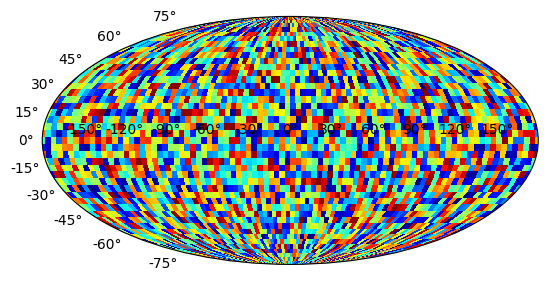

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
arr = np.random.rand(45, 90)

lon = np.linspace(-np.pi, np.pi,90)
lat = np.linspace(-np.pi/2., np.pi/2.,45)
Lon,Lat = np.meshgrid(lon,lat)

im = ax.pcolormesh(Lon,Lat,arr, cmap=plt.cm.jet)

plt.show()

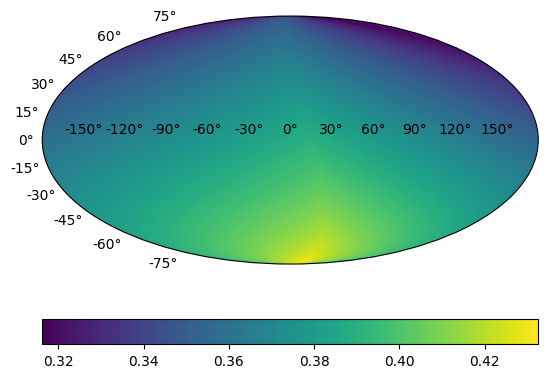

In [9]:
interp = LinearNDInterpolator(list(zip(real_PA - 180, real_inc)), error)
lon = np.linspace(-np.pi, np.pi, 900)
lat = np.linspace(-np.pi/2., np.pi/2., 450)
Lon,Lat = np.meshgrid(lon,lat)
Error = interp(Lon, Lat)
# Error = np.random.uniform(0, 1, (45, 90))
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Lon, Lat, Error, cmap='viridis')
fig.colorbar(im, orientation='horizontal')
plt.show()

In [10]:
np.radians(np.linspace(0, 360, 100))

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [11]:
interp(0.1, np.pi / 100)

array(0.38804847)